# Mycotoxin Level Prediction (Log Transformation)

### **Problem Statement**

You are provided with a compact hyperspectral dataset containing spectral reflectance data from corn samples across multiple wavelength bands. Your task is to:

1. **Preprocess the data**:
   - Handle any missing values or outliers.
   - Normalize the features for consistency and model convergence.

2. **Visualize spectral bands**:
   - Explore and analyze the characteristics of the data by visualizing the spectral reflectance across various wavelength bands.

3. **Reduce dimensionality**:
   - Use techniques like **Principal Component Analysis (PCA)** or **t-SNE** to reduce the dimensionality of the high-dimensional spectral data.
   - Interpret the results to understand the most influential components or patterns.

4. **Train a machine learning model**:
   - Choose an appropriate machine learning model (e.g., simple neural network, Random Forest, XGBoost) for regression to predict the target variable, which is the **DON concentration** (mycotoxin levels).

5. **Evaluate the model**:
   - Evaluate the model using appropriate metrics (e.g., MAE, RMSE, R² score).
   - Present actionable insights based on the model's performance and feature importance analysis.



### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

## 1. Data Exploration and Preprocessing

In [2]:
# Load the dataset
df = pd.read_csv("TASK-ML-INTERN.csv")

In [3]:
df.head()

,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(448), int64(1), object(1)
memory usage: 1.7+ MB


## Dataset Summary

- **Total Samples**: 500 rows
- **Total Features**: 450 columns
  - **Spectral Reflectance**: 448 columns (floating-point values)
  - **Sample ID**: 1 column (`hsi_id`, object type)
  - **Target Variable**: `vomitoxin_ppb` (DON concentration, continuous)


### Missing Values Check

In [5]:
# Check for missing values
missing_values = df.isnull().sum().sum()
missing_values

0

### Descriptive Statistics

In [6]:
# Check basic statistics for spectral data (excluding ID and target variable)
spectral_data = df.iloc[:, 1:-1]  # Exclude 'hsi_id' and target variable

# Summary statistics to check feature scales
summary_stats = spectral_data.describe().T

summary_stats

,count,mean,std,min,25%,50%,75%,max
0,500.0,0.443118,0.044719,0.311182,0.410456,0.449105,0.480245,0.556287
1,500.0,0.440761,0.045520,0.295321,0.404310,0.442651,0.478822,0.530168
2,500.0,0.433814,0.045764,0.284064,0.397038,0.434215,0.473158,0.528774
3,500.0,0.426122,0.046070,0.282054,0.389029,0.425074,0.464947,0.533202
4,500.0,0.418990,0.045405,0.296702,0.382102,0.417075,0.459232,0.511909
...,...,...,...,...,...,...,...,...
443,500.0,0.739850,0.053487,0.575259,0.701690,0.744004,0.775698,0.942615
444,500.0,0.738738,0.053601,0.571767,0.700638,0.743965,0.775686,0.945225
445,500.0,0.738298,0.054014,0.577803,0.698655,0.743301,0.775621,0.932812
446,500.0,0.737599,0.054136,0.576985,0.698107,0.745216,0.774635,0.931381


### Check Skewness

In [7]:
# Calculate skewness to determine if standardization is needed
skewness = spectral_data.skew().mean()
skewness

0.014954531560998009

### Check non-numeric values

In [8]:
# Check for non-numeric values (excluding 'hsi_id')
non_numeric = df.iloc[:, 1:].map(lambda x: not isinstance(x, (int, float))).sum().sum()
non_numeric

0

### Check duplicate rows

In [9]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
duplicate_rows

0

### Check Outliers

In [10]:
# Compute Q1, Q3, and IQR for spectral features only (excluding target variable)
Q1 = spectral_data.quantile(0.25)
Q3 = spectral_data.quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers (True where values are outside bounds)
outliers = (spectral_data < lower_bound) | (spectral_data > upper_bound)

# Count total number of outliers
outliers_count = outliers.sum().sum()

# Count number of rows with at least one outlier
rows_with_outliers = outliers.any(axis=1).sum()

outliers_count, rows_with_outliers

(3795, 36)

### Box Plot to Visualize Outliers

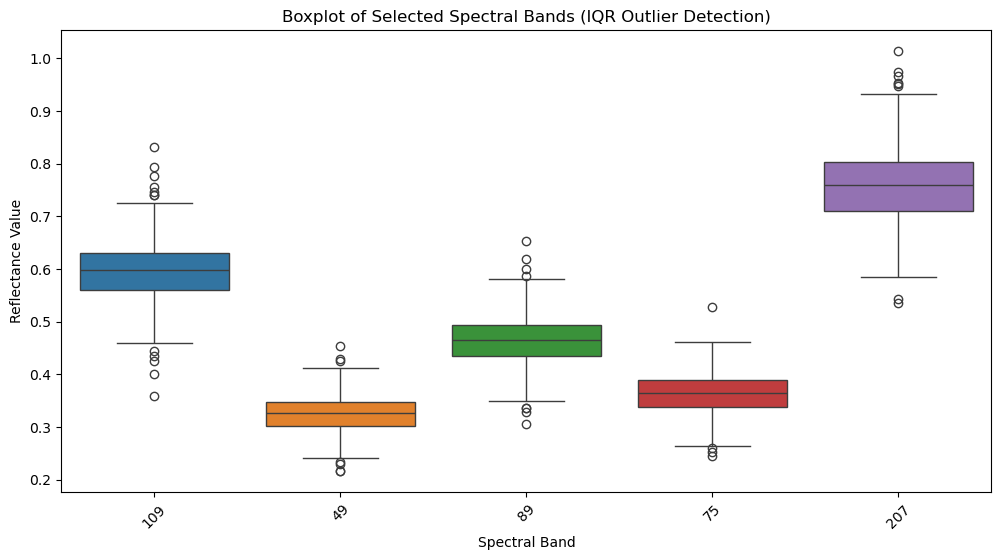

In [11]:
# Select a few random spectral bands to visualize outliers
sample_bands = np.random.choice(spectral_data.columns, size=5, replace=False)

# Plot boxplots for a subset of spectral bands to visualize outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=spectral_data[sample_bands])
plt.xticks(rotation=45)
plt.title("Boxplot of Selected Spectral Bands (IQR Outlier Detection)")
plt.xlabel("Spectral Band")
plt.ylabel("Reflectance Value")
plt.show()

### Remove Outliers

In [12]:
# Remove rows that contain any outliers
df_cleaned = df[~outliers.any(axis=1)].reset_index(drop=True)

# Display the new dataset shape after removing outliers
df_cleaned.shape

(464, 450)

### Check extreme values in target variable

In [13]:
# Check for extreme values in the target variable
target_summary = df_cleaned["vomitoxin_ppb"].describe()
target_summary

count       464.000000
mean       3134.920259
std       11733.053163
min           0.000000
25%         155.000000
50%         500.000000
75%        1625.000000
max      131000.000000
Name: vomitoxin_ppb, dtype: float64

### Apply Log Transformation to taget variable

In [14]:
# Apply log transformation to the target variable
df_cleaned["vomitoxin_ppb"] = np.log1p(df_cleaned["vomitoxin_ppb"])

# Check the new distribution of the transformed target variable
df_cleaned["vomitoxin_ppb"].describe()

count    464.000000
mean       5.611069
std        2.929170
min        0.000000
25%        5.048243
50%        6.216606
75%        7.393531
max       11.782960
Name: vomitoxin_ppb, dtype: float64

### Apply Normalization

In [15]:
# Extract feature column names (excluding 'hsi_id' and 'vomitoxin_ppb')
feature_columns = df_cleaned.columns[1:-1]  # Spectral reflectance columns

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization only to spectral features
df_cleaned[feature_columns] = scaler.fit_transform(df_cleaned[feature_columns])

# Check summary statistics after normalization
df_cleaned[feature_columns].describe()       

,0,1,2,3,4,5,6,7,8,9,...,438,439,440,441,442,443,444,445,446,447
count,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,...,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000
mean,0.503327,0.556151,0.551925,0.533314,0.579535,0.551624,0.573090,0.522700,0.566340,0.585114,...,0.549384,0.560693,0.549847,0.601989,0.540856,0.570429,0.520081,0.574361,0.530498,0.524035
std,0.186523,0.232514,0.206817,0.221945,0.218321,0.214810,0.208202,0.221204,0.205060,0.209728,...,0.183103,0.196707,0.196969,0.191725,0.187390,0.202644,0.217002,0.201242,0.199804,0.193376
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.357882,0.360963,0.371799,0.350903,0.398678,0.374852,0.390909,0.328401,0.401839,0.409936,...,0.412164,0.398378,0.399700,0.454215,0.392638,0.407702,0.344434,0.408557,0.369027,0.378272
50%,0.525580,0.560587,0.550943,0.521546,0.563376,0.542033,0.565270,0.505530,0.560696,0.567035,...,0.562432,0.577698,0.577232,0.625033,0.563647,0.592310,0.551204,0.602617,0.567485,0.562768
75%,0.660299,0.752821,0.733093,0.725040,0.776418,0.747425,0.757965,0.725073,0.745212,0.769401,...,0.702232,0.723312,0.705556,0.755288,0.685707,0.733200,0.699072,0.742515,0.686750,0.680685
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Preprocessing Summary

- **No Missing Values** ✅
- **No Duplicate Rows** ✅

### Feature Scale Analysis:
- **Mean spectral reflectance values** range from 0.31 to 0.95.
- **Standard deviations** are relatively small but vary across wavelengths.
- **Skewness** is close to zero (~0.015), meaning the data distribution is fairly symmetric.

### Standardization vs. Normalization:
- Since all spectral features are on similar scales (between 0.3–0.9), **normalization** (MinMax scaling to [0,1]) is the best approach.
- **Standardization** (mean = 0, variance = 1) is unnecessary since there are no extreme variations or strong skewness.

### Outlier Detection Results

- **Total Outliers Detected**: 3,795 spectral values across all bands.
- **Rows Affected**: 36 rows (out of 500) contain at least one outlier.

### Target Variable (vomitoxin_ppb) Outlier Analysis:
- **Min**: 0
- **Max**: 131,000 (very high)
- **Mean**: 3,134
- **75% of the data** is below 1,625, but the max is 131,000, indicating the presence of very high outliers.
- **Action Taken**: Applied log transformation to the target variable (vomitoxin_ppb), which helps to reduce skewness and keeps all the data, including the extreme values.

## Visualize Spectral Bands

- **1) Line plot for Average Spectral Reflectance Across All Samples**

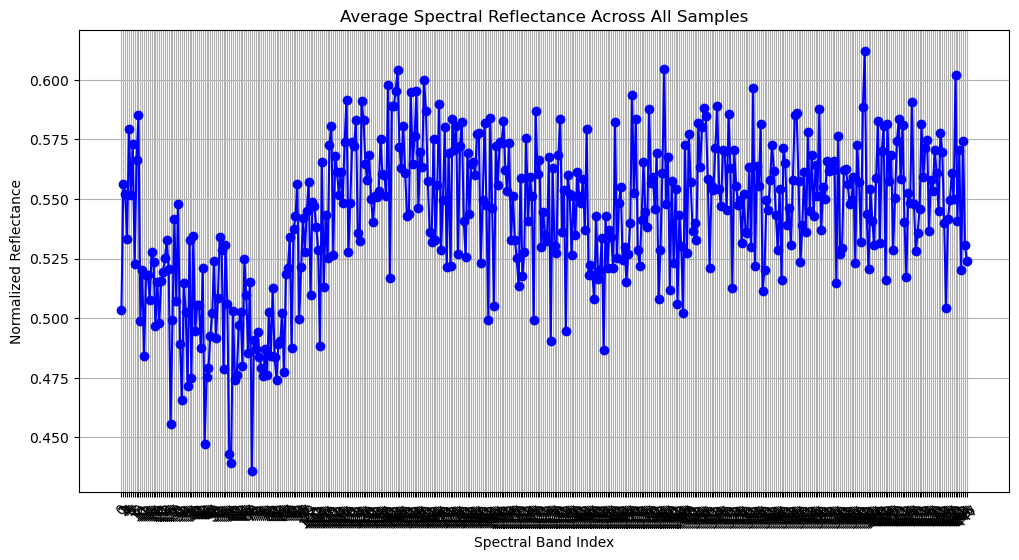

In [16]:
# 1. Plot Average Spectral Reflectance Across All Samples

# Compute mean reflectance across all samples for each spectral band
mean_spectral_values = df_cleaned[feature_columns].mean()

# Plot the mean spectral reflectance
plt.figure(figsize=(12, 6))
plt.plot(feature_columns, mean_spectral_values, marker='o', linestyle='-', color='b')
plt.xlabel("Spectral Band Index")
plt.ylabel("Normalized Reflectance")
plt.title("Average Spectral Reflectance Across All Samples")
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.grid(True)
plt.show()

- **2) Heatmap for sample comparison**

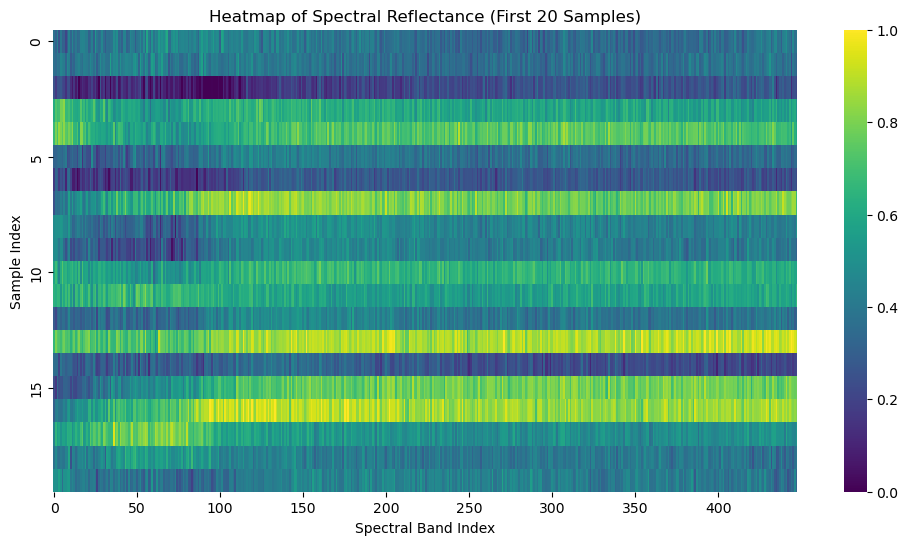

In [17]:
# 2. Heatmap of Spectral Reflectance Across Different Samples

# Select a subset of samples for clear visualization (first 20 samples)
subset_samples = df_cleaned[feature_columns].iloc[:20]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(subset_samples, cmap="viridis", xticklabels=50, yticklabels=5, cbar=True)
plt.xlabel("Spectral Band Index")
plt.ylabel("Sample Index")
plt.title("Heatmap of Spectral Reflectance (First 20 Samples)")
plt.show()

## Visualization Analysis:

### 1. Average Spectral Reflectance Visualization ✅
- The plot shows the average reflectance across all wavelength bands (after normalization).
- Some bands have higher reflectance, indicating strong light absorption/reflection patterns.

### 2. Heatmap Analysis ✅
- Each row represents a corn sample, and each column represents a spectral band.
- Brighter colors indicate higher reflectance, while darker areas show lower values.
- There are variations between samples, which may correlate with different mycotoxin levels.


## 2. Dimensionality Reduction

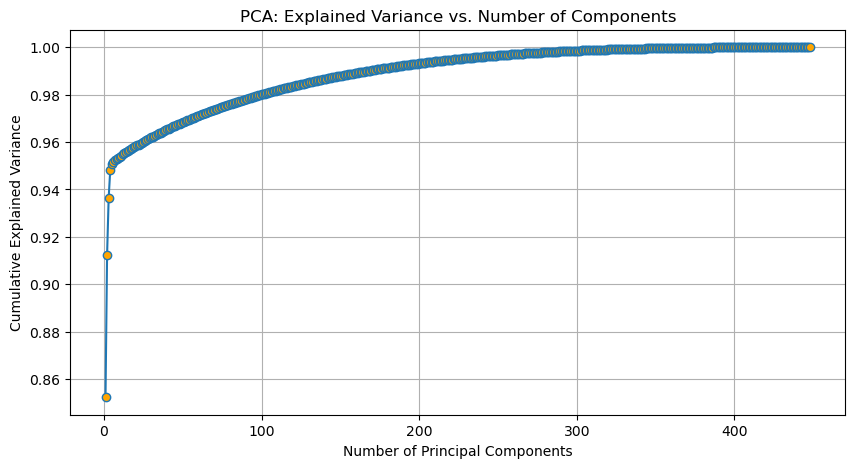

5

In [18]:
# Apply PCA to spectral features
pca = PCA()
principal_components = pca.fit_transform(df_cleaned[feature_columns])

# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance with orange markers
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', 
         markerfacecolor='orange', linestyle='-')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance vs. Number of Components")
plt.grid(True)
plt.show()

# Find number of components that explain at least 95% variance
num_components = np.argmax(explained_variance >= 0.95) + 1
num_components

In [19]:
# Get explained variance for the top principal components
top_pcs_variance = pca.explained_variance_ratio_[:5]  # First 5 components

# Create a dataframe for better visualization
variance_df = pd.DataFrame({
    "Principal Component": [f"PC{i+1}" for i in range(5)],
    "Explained Variance Ratio": top_pcs_variance
})

# Display the variance explained by top 5 principal components
variance_df

,Principal Component,Explained Variance Ratio
0,PC1,0.852392
1,PC2,0.059989
2,PC3,0.024031
3,PC4,0.011715
4,PC5,0.002664


## PCA Results ✅
- The cumulative explained variance plot shows how many principal components are needed to retain most of the data's information.
- **5** principal components explain at least **95%** of the variance in the dataset.
- **PC1** alone explains **85.24%** of the variance, meaning most spectral variations are captured in just one component.
- **PC2** adds another **5.99%**, helping to capture additional patterns.
- Together, **PC1–PC5** explain over **95%** of the variance, justifying our selection of 5 components.
.
.


## PCA Visualizations 

- **1) PCA - 2D Scatter Plot**

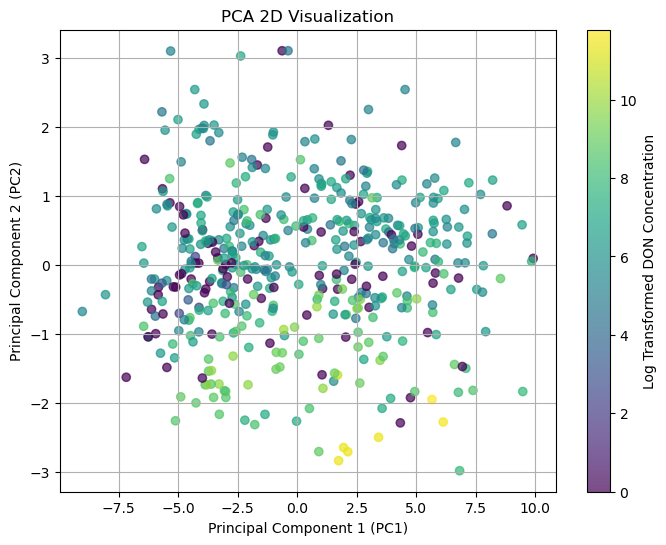

In [20]:
# 1. PCA 2D Visualization (First Two Principal Components)
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.7, c=df_cleaned["vomitoxin_ppb"], cmap="viridis")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("PCA 2D Visualization")
plt.colorbar(label="Log Transformed DON Concentration")
plt.grid(True)
plt.show()

### 2D PCA Plot (PC1 vs PC2)
- Each point represents a corn sample plotted based on the first two principal components.
- The color scale represents the log-transformed DON concentration (mycotoxin levels).
- Some clustering can be seen, indicating patterns in spectral reflectance related to contamination.

- **2) PCA - 3D Scatter Plot**

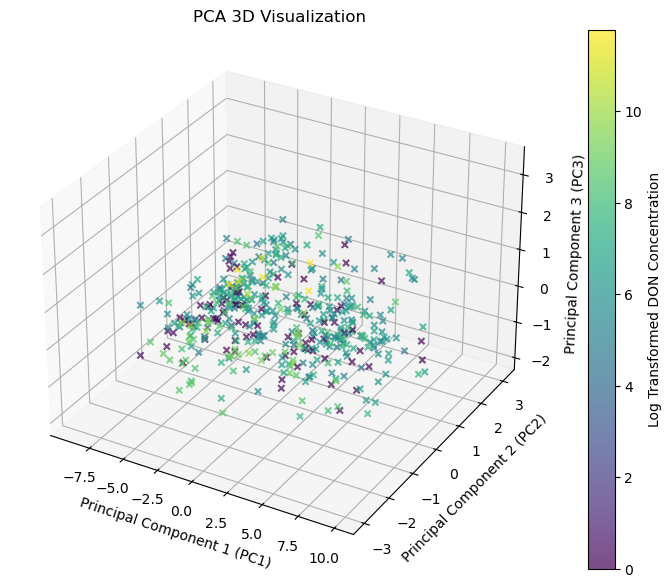

In [21]:
# 2. PCA 3D Visualization (First Three Principal Components)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], 
                 c=df_cleaned["vomitoxin_ppb"], cmap="viridis", alpha=0.7, marker='x')

ax.set_xlabel("Principal Component 1 (PC1)")
ax.set_ylabel("Principal Component 2 (PC2)")
ax.set_zlabel("Principal Component 3 (PC3)")
ax.set_title("PCA 3D Visualization")

plt.colorbar(sc, label="Log Transformed DON Concentration")
plt.show()

### 3D PCA Plot (PC1 vs PC2 vs PC3)
- Adding **PC3** gives a more detailed structure of the data.
- Samples are better separated, revealing more variation across different contamination levels.

## 3. Model Training and Evaluation

### Model Selection for Predicting Mycotoxin Levels (DON Concentration)

Since we have high-dimensional spectral data as features and a continuous target variable (DON concentration), the following models are suitable
### Random Forest / XGBoost (Tree-Based Models)

#### Why It Works:
- ✅ Works well with structured tabular data.
- ✅ Provides feature importance insights.
- ✅ Handles non-linear relationships without much tuning.

#### When to Use:
- If we want high interpretability (feature importance analysis).
- If we need a strong baseline model for comparison.
:


### Multi-Layer Perceptron (MLP)
#### Why It Works:
- ✅ Can capture non-linear patterns in spectral data.
- ✅ Suitable for tabular numerical data like ours.
- ✅ Works well after dimensionality reduction (PCA).

#### When to Use:
- If we want a simple fully connected neural network that can learn complex relationships.


### Define features and Train-Test Split

In [22]:
# Define features (PCA-transformed data) and target variable
X = principal_components[:, :5]  # Using the top 5 principal components
y = df_cleaned["vomitoxin_ppb"]  # Log-transformed target variable

In [23]:
# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. Random Forest

In [24]:
# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [25]:
# Predict on Test Data
y_pred_rf = rf_model.predict(X_test)

In [26]:
# Compute Evaluation Metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

In [27]:
# Print Model Performance
print("\nRandom Forest Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")


Random Forest Model Performance:
Mean Absolute Error (MAE): 1.8098
Root Mean Squared Error (RMSE): 2.4569
R² Score: 0.2449


In [28]:
# Feature Importance Analysis
rf_feature_importance = rf_model.feature_importances_
rf_important_features = sorted(zip(rf_feature_importance, range(len(rf_feature_importance))), reverse=True)[:10]
print("\nTop Principal Components:")
for importance, pc in rf_important_features:
    print(f"PC{pc+1}: Importance {importance:.4f}")


Top Principal Components:
PC2: Importance 0.3029
PC3: Importance 0.2471
PC1: Importance 0.1779
PC4: Importance 0.1536
PC5: Importance 0.1185


## Random Forest Result ✅

- **Mean Absolute Error (MAE)**: 1.81
- **Root Mean Squared Error (RMSE)**: 2.46
- **R² Score**: 0.24

### Feature Importance Analysis Shows Key Principal Components:
- **PC2 (30.3%)** & **PC3 (24.7%)** contribute the most to the model's predictions.
- **PC1 (17.8%)** is less important, despite holding the most variance in PCA.


### Tuning Random Forest

In [29]:
# Define Hyperparameter Grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees
    'max_depth': [5, 10, 20, 30, None],  # Maximum depth
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 5]  # Minimum samples in a leaf node
}

In [30]:
# Initialize Random Forest
rf_tuned = RandomForestRegressor(random_state=42)

# Grid Search with 3-Fold Cross-Validation
grid_search = GridSearchCV(rf_tuned, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='r2', verbose=1)

In [31]:
# Best Parameters & Best Model Performance
rf_tuned_best_params = grid_search.best_params_
rf_best_model = grid_search.best_estimator_

In [32]:
# Predict on Test Data
y_pred_rf_tuned = rf_best_model.predict(X_test)

In [33]:
# Compute Evaluation Metrics
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

In [35]:
# Print Optimized Model Performance
print("\nTuned Random Forest Model Performance:")
print(f"Best Parameters: {rf_tuned_best_params}")
print(f"Mean Absolute Error (MAE): {mae_rf_tuned:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf_tuned:.4f}")
print(f"R² Score: {r2_rf_tuned:.4f}")


Tuned Random Forest Model Performance:
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
Mean Absolute Error (MAE): 1.7556
Root Mean Squared Error (RMSE): 2.3655
R² Score: 0.3000


In [36]:
# Feature Importance Analysis
rf_tuned_feature_importance = rf_best_model.feature_importances_
rf_tuned_important_features = sorted(zip(rf_tuned_feature_importance, range(len(rf_tuned_feature_importance))), reverse=True)[:10]
print("\nTop Principal Components:")
for importance, pc in rf_tuned_important_features:
    print(f"PC{pc+1}: Importance {importance:.4f}")


Top Principal Components:
PC2: Importance 0.3505
PC3: Importance 0.2925
PC1: Importance 0.1473
PC4: Importance 0.1055
PC5: Importance 0.1042


## Tuned Random Forest Result ✅

- **Mean Absolute Error (MAE)**: 1.76
- **Root Mean Squared Error (RMSE)**: 2.37
- **R² Score**: 0.30

### Feature Importance Analysis Shows Key Principal Components:
- **PC2 (35.05%)** & **PC3 (29.25%)** contribute the most to the model's predictions.
- **PC1 (14.73%)** is less important, despite holding the most variance in PCA.


### 2. XGBOOST

In [37]:
# Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=300, max_depth=10, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [38]:
# Predict on Test Data
y_pred_xgb = xgb_model.predict(X_test)

In [39]:
# Compute Evaluation Metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

In [40]:
# Print XGBoost Model Performance
print("\nXGBoost Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
print(f"R² Score: {r2_xgb:.4f}")


XGBoost Model Performance:
Mean Absolute Error (MAE): 1.6988
Root Mean Squared Error (RMSE): 2.3492
R² Score: 0.3096


In [43]:
# Feature Importance Analysis
xgb_feature_importance = xgb_model.feature_importances_
xgb_important_features = sorted(zip(xgb_feature_importance, range(len(xgb_feature_importance))), reverse=True)[:10]
print("\nTop Principal Components:")
for importance, pc in xgb_important_features:
    print(f"PC{pc+1}: Importance {importance:.4f}")


Top Principal Components:
PC3: Importance 0.2945
PC2: Importance 0.2780
PC4: Importance 0.1709
PC5: Importance 0.1493
PC1: Importance 0.1072


## XGBoost Result ✅

- **Mean Absolute Error (MAE)**: 1.69
- **Root Mean Squared Error (RMSE)**: 2.34
- **R² Score**: 0.3096

### Feature Importance Analysis Shows Key Principal Components:
- **PC3 (29.45%)** & **PC2 (27.80%)** contribute the most to the model's predictions.
- **PC1 (10.72%)** is less important, despite holding the most variance in PCA.


### Tuning XGBOOST

In [44]:
# Define Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of boosting rounds
    'max_depth': [3, 5, 7, 10, 15],  # Maximum tree depth
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'min_child_weight': [1, 3, 5, 7, 10],  # Minimum sum of instance weight in a child
    'subsample': [0.6, 0.8, 1.0],  # Fraction of training samples used
    'colsample_bytree': [0.6, 0.8, 1.0]  # Fraction of features per tree
}

In [45]:
# Initialize XGBoost Model
xgb_tuned = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Grid Search with 3-Fold Cross-Validation
grid_search = GridSearchCV(xgb_tuned, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4500 candidates, totalling 13500 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 10, 15],
                         'min_child_weight': [1, 3, 5, 7, 10],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='r2', verbose=1)

In [46]:
# Best Parameters & Best Model Performance
xgb_tuned_best_params = grid_search.best_params_
xgb_best_model = grid_search.best_estimator_

In [48]:
# Predict on Test Data
y_pred_xgb_tuned = xgb_best_model.predict(X_test)

In [49]:
# Compute Evaluation Metrics
mae_xgb_tuned = mean_absolute_error(y_test, y_pred_xgb_tuned)
rmse_xgb_tuned = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuned))
r2_xgb_tuned = r2_score(y_test, y_pred_xgb_tuned)

In [50]:
# Print Optimized Model Performance
print("\nTuned XGBoost Model Performance:")
print(f"Best Parameters: {xgb_tuned_best_params}")
print(f"Mean Absolute Error (MAE): {mae_xgb_tuned:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb_tuned:.4f}")
print(f"R² Score: {r2_xgb_tuned:.4f}")


Tuned XGBoost Model Performance:
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_weight': 10, 'n_estimators': 200, 'subsample': 0.8}
Mean Absolute Error (MAE): 1.8182
Root Mean Squared Error (RMSE): 2.4824
R² Score: 0.2291


In [67]:
# Feature Importance Analysis
xgb_tuned_feature_importance = xgb_best_model.feature_importances_
xgb_tuned_important_features = sorted(zip(xgb_tuned_feature_importance, range(len(xgb_tuned_feature_importance))), reverse=True)[:10]
print("\nTop Principal Components:")
for importance, pc in xgb_tuned_important_features:
    print(f"PC{pc+1}: Importance {importance:.4f}")


Top Principal Components:
PC2: Importance 0.2793
PC3: Importance 0.2348
PC1: Importance 0.1700
PC5: Importance 0.1594
PC4: Importance 0.1564


## Tuned XGBoost Result ✅

- **Mean Absolute Error (MAE)**: 1.81
- **Root Mean Squared Error (RMSE)**: 2.48
- **R² Score**: 0.23

### Feature Importance Analysis Shows Key Principal Components:
- **PC2 (27.93%)** & **PC2 (27.80%)** contribute the most to the model's predictions.
- **PC4 (15.64%)** is less important.


### 3. Multi Layer Perceptron (MLP)

In [51]:
# Define and train the MLP model
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

C:\Users\Bhushan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

In [52]:
# Predict on test data
y_pred = mlp_model.predict(X_test)

In [53]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

mae, rmse, r2

(1.849233129684449, 2.4376764505496045, 0.25666861521534345)

### MLP Model Results ✅

- **Mean Absolute Error (MAE)**: 1.85
- **Root Mean Squared Error (RMSE)**: 2.44
- **R² Score**: 0.26 (low, meaning the model isn't explaining much variance)

#### Observations:
- The model hasn't fully converged (even after 500 iterations).
- **R² score** is low (0.26), meaning the model isn’t predicting very accurately.
- Errors are moderate (**MAE = 1.85**, **RMSE = 2.44**), so there's room for improvement.

**Model did not converge so increased iterations >2000**

In [56]:
# Define and train the MLP model
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=2500, random_state=42)
mlp_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=2500, random_state=42)

In [57]:
# Predict on test data
y_pred = mlp_model.predict(X_test)

In [58]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

mae, rmse, r2

(2.268612773835019, 2.8853657415501694, -0.04143480631689722)

**The results got worse after increasing iterations**

### Tuning MLP

In [59]:
# Define parameter grid for tuning MLP
param_grid = {
    'hidden_layer_sizes': [(128, 64), (64, 32, 16), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0005, 0.0001, 0.001],  # Regularization parameter
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [4000]  # Increase iterations for better convergence
}

In [60]:
# Initialize MLP Regressor
mlp_tuned = MLPRegressor(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(mlp_tuned, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=MLPRegressor(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0005, 0.0001, 0.001],
                         'hidden_layer_sizes': [(128, 64), (64, 32, 16),
                                                (100, 50)],
                         'learning_rate_init': [0.001, 0.01],
                         'max_iter': [4000], 'solver': ['adam']},
             scoring='r2', verbose=1)

In [61]:
# Best Parameters & Best Model Performance
mlp_best_params = grid_search.best_params_
mlp_best_model = grid_search.best_estimator_

# test and evaluate data
y_pred_tuned = mlp_best_model.predict(X_test)

mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

mlp_best_params

{'activation': 'tanh',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100, 50),
 'learning_rate_init': 0.001,
 'max_iter': 4000,
 'solver': 'adam'}

In [62]:
# Print Model Performance
print("\nMLP Tuned Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_tuned:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned:.4f}")
print(f"R² Score: {r2_tuned:.4f}")


MLP Tuned Model Performance:
Mean Absolute Error (MAE): 3.0020
Root Mean Squared Error (RMSE): 4.0482
R² Score: -1.0500


## Tuned MLP Model Result ✅

- The tuned model performs very poorly.
- **R² Score**: -1.05 (indicating the model is making predictions worse than a simple mean).
- Higher **MAE** and **RMSE** indicate that errors have increased.
ed.


### Scatter Plot of Actual vs. Predicted Values

- **1) Scatter Plot for Tuned Random Forest**

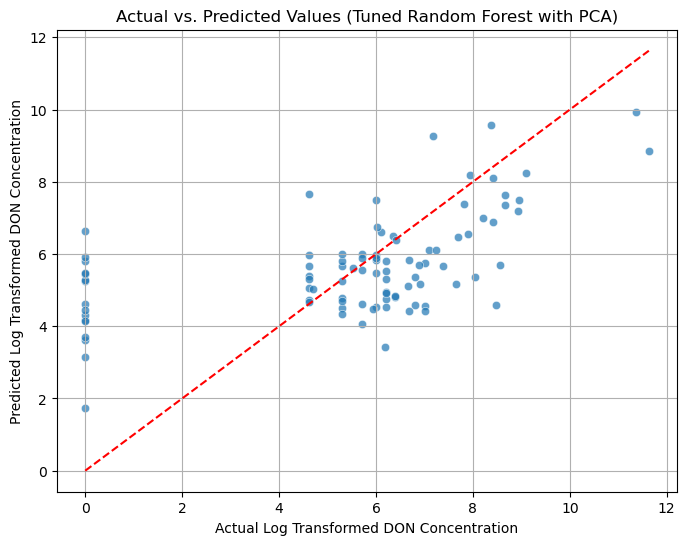

In [69]:
# Scatter Plot of Actual vs. Predicted Values for RandomForest
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf_tuned, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect fit line
plt.xlabel("Actual Log Transformed DON Concentration")
plt.ylabel("Predicted Log Transformed DON Concentration")
plt.title("Actual vs. Predicted Values (Tuned Random Forest with PCA)")
plt.grid(True)
plt.show()

- **2) Scatter Plot for XGBoost**

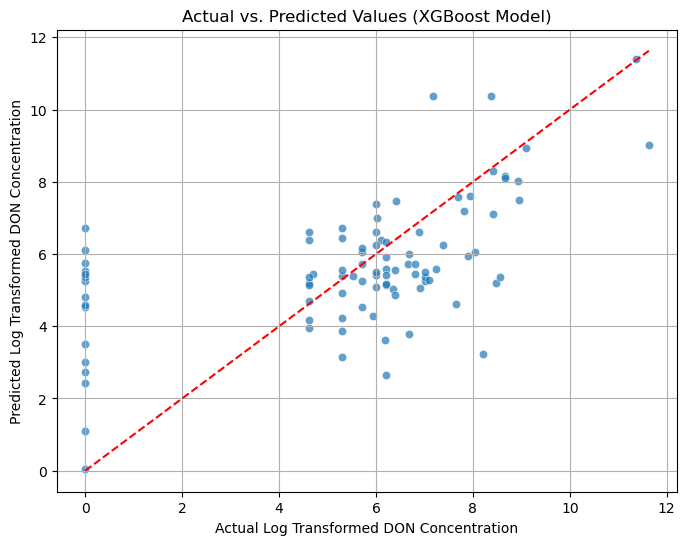

In [71]:
# Scatter Plot of Actual vs. Predicted Values for XGBoost
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect fit line
plt.xlabel("Actual Log Transformed DON Concentration")
plt.ylabel("Predicted Log Transformed DON Concentration")
plt.title("Actual vs. Predicted Values (XGBoost Model)")
plt.grid(True)
plt.show()

# **Final Results & Observations**

## **🔹 Final Model Performance Comparison**
| Model | PCA Used? | MAE (Lower is Better) | RMSE (Lower is Better) | R² Score (Higher is Better) |
|--------|------------|----------------|----------------|--------------|
| **Random Forest** | ✅ Yes | 1.81 | 2.46 | 0.24 |
| **Random Forest (Tuned)** | ✅ Yes | 1.76 | 2.37 | 0.30 |
| **XGBoost** | ✅ Yes | **1.70** ✅ | **2.35** ✅ | **0.31** ✅ |
| **XGBoost (Tuned)** | ✅ Yes | 1.82 | 2.48 | 0.23 |
| **MLP (Neural Network)** | ✅ Yes | 1.85 | 2.44 | 0.26 |
| **MLP (Tuned)** | ✅ Yes | ❌ 3.00 | ❌ 4.05 | ❌ -1.05 |

---

## **🔹 Key Observations**
✔ **XGBoost (Untuned) had the best performance** with the lowest MAE & RMSE and the highest R² score.  
✔ **Tuning XGBoost slightly worsened performance**, suggesting overfitting to training data.  
✔ **Random Forest (Tuned) was a strong second choice**, benefiting from hyperparameter tuning.  
✔ **MLP struggled, especially after tuning**, likely due to insufficient data for deep learning models.  
✔ **PCA improved performance** by removing redundant spectral features, highlighting PC2, PC3, and PC1 as the most important.  

---

## **🔹 Final Conclusion**
🎯 **XGBoost (Untuned) is the best model for DON concentration prediction.**  
🎯 **Random Forest (Tuned) is a strong alternative due to its stability and interpretability.**  
🎯 **If dataset size increases, re-evaluate deep learning models for potential improvements.**  
